# Practical week 8: data loaders and a first CNN

## Set up and dataset

We'll start by loading the MNIST dataset. This comes in the form of the `Dataset` class which can subsequently be passed to the `Dataloader` class to make reading random mini-batches easy.



We're using a few more imports here: torchvision contains many useful operations related specifically to images. It also contains some standard datasets in a prepackaged form. Matplotlib is for displaying images.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

Let's set up the datasets - this will download the dataset to the local (colab) file system.

In [2]:
train_data = datasets.MNIST(
    root="data", train=True, transform=ToTensor(), download=True
)
test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())

These are `Dataset` objects. They provide two crucial methods. One returns a length so that `len(train_data)` returns the number of elements in the dataset. Second is `__getitem__` which takes the index of data item as input and returns the item (for example, it might return an image and the corresponding label). Later, we will write our own custom dataset.

In [3]:
image, label = train_data.__getitem__(0)
# Or equivalently: image, label = train_data[0]
print(image.shape)
print(label)

torch.Size([1, 28, 28])
5


Datasets can be used with a `Dataloader` as a convenient way to manage requesting random mini-batches and iterating over datasets. The data loader itself is an iterable object that, in this case, returns pairs of input images and corresponding labels of the requested batch size.

In [4]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=100, shuffle=True, num_workers=1
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=100, shuffle=True, num_workers=1
)

Now that we have a dataset and dataloader, let's take a look at some of the data in our dataset. We'll load a random mini-batch and then display the first 25 images along with their labels.

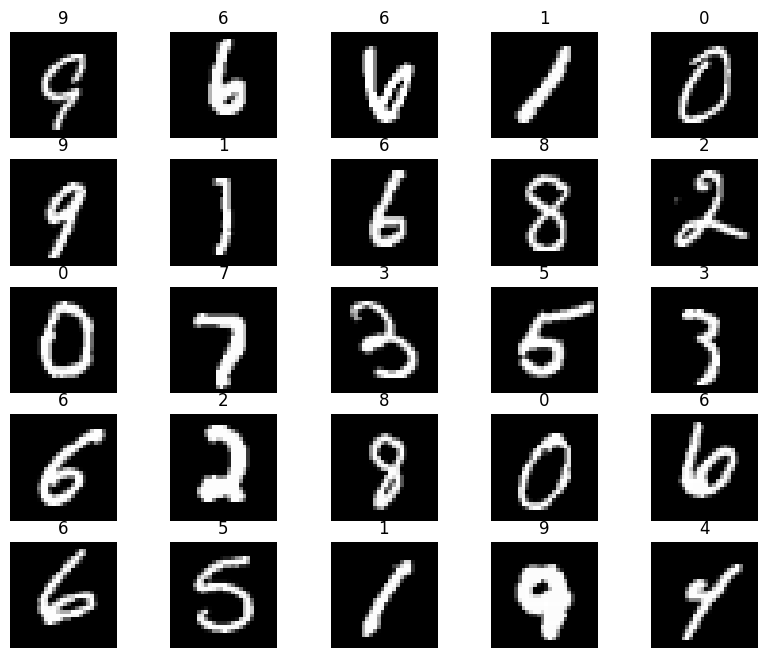

In [5]:
images, labels = next(iter(train_loader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i + 1)
    plt.title(labels[i].item())
    plt.axis("off")
    plt.imshow(images[i, :].squeeze(), cmap="gray")
plt.show()

## Defining the network

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2
        )
        self.sigmoid = nn.Tanh()  # LeCun actually uses hyperbolic tangent, though the paper talks about "sigmoidal function"
        self.meanpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0
        )
        self.fc1 = nn.Linear(in_features=5 * 5 * 16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # Input x has dimensions B x 1 x 28 x 28, B is batch size
        # Comments show tensor size output from previous line
        x = self.conv1(x)
        # B x 6 x 28 x 28
        x = self.sigmoid(x)
        x = self.meanpool(x)
        # B x 6 x 14 x 14
        x = self.conv2(x)
        # B x 16 x 10 x 10
        x = self.sigmoid(x)
        x = self.meanpool(x)
        # B x 16 x 5 x 5
        x = x.view(x.size(0), -1)
        # Flattened to B x 400
        x = self.fc1(x)
        # B x 120
        x = self.sigmoid(x)
        x = self.fc2(x)
        # B x 84
        x = self.sigmoid(x)
        x = self.fc3(x)
        # B x 10
        return x


# Instantiate the model - this initialises all weights and biases
model = LeNet()

## Training

Different to previous practicals, we are using random mini-batches here. This means we have two loops, an outer one over "epochs" (an epoch means every training element has been seen once) and an inner one over random mini-batches as provided by the data loader. This will take a few minutes to run.

In [7]:
num_epochs = 10

optim = torch.optim.SGD(model.parameters(), lr=0.1)
iterations_per_epoch = len(train_loader)

# Set up the loss function for multiclass classification
loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        output = model(images)
        loss = loss_func(output, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if (i + 1) % 100 == 0:
            print(
                "Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}".format(
                    epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()
                )
            )
        total_loss += loss
    print("Total loss over epoch {}: {:.2f}".format(epoch + 1, total_loss))

Epoch [1/10], Iteration [100/600], Loss: 0.8915
Epoch [1/10], Iteration [200/600], Loss: 0.4007
Epoch [1/10], Iteration [300/600], Loss: 0.3242
Epoch [1/10], Iteration [400/600], Loss: 0.2816
Epoch [1/10], Iteration [500/600], Loss: 0.2637
Epoch [1/10], Iteration [600/600], Loss: 0.2722
Total loss over epoch 1: 352.66
Epoch [2/10], Iteration [100/600], Loss: 0.1195
Epoch [2/10], Iteration [200/600], Loss: 0.2050
Epoch [2/10], Iteration [300/600], Loss: 0.0838
Epoch [2/10], Iteration [400/600], Loss: 0.1887
Epoch [2/10], Iteration [500/600], Loss: 0.1459
Epoch [2/10], Iteration [600/600], Loss: 0.1581
Total loss over epoch 2: 103.55
Epoch [3/10], Iteration [100/600], Loss: 0.1494
Epoch [3/10], Iteration [200/600], Loss: 0.0441
Epoch [3/10], Iteration [300/600], Loss: 0.1571
Epoch [3/10], Iteration [400/600], Loss: 0.0945
Epoch [3/10], Iteration [500/600], Loss: 0.0880
Epoch [3/10], Iteration [600/600], Loss: 0.0944
Total loss over epoch 3: 65.76
Epoch [4/10], Iteration [100/600], Loss: 

Do you think this has converged after 10 epochs? If not, don't run any more for now. See how it performs below then come back and run more if you think performance is still improving.

In [13]:
x = torch.randn(100, 1)
y = torch.randn(
    100,
)
z = x - y
print(z.shape)

torch.Size([100, 100])


## Evaluation

Let's see how well it performs on the test set.

In [8]:
correct = 0
total = 0
for images, labels in test_loader:
    output = model(images)
    pred_y = torch.argmax(output, 1)
    correct += (pred_y == labels).sum()
    total += float(labels.size(0))
accuracy = correct / total
print("Test Accuracy of the model on the 10000 test images: %.2f" % accuracy)

Test Accuracy of the model on the 10000 test images: 0.99


Pretty amazing huh?! A pretty simple convolutional neural network, a couple of minutes training in your web browser and you can classify 10,000 hand written digits in a few seconds with nearly 100% accuracy! Yann LeCun got to 99.05% test set accuracy with this architecture. You could also get there if you tuned hyperparameters a bit (number of epochs, learning rate, batch size, what optimiser you use).

But before you try to improve it, let's see some examples that it is classifying. This code will display 25 images from the test set, the true label and the classification predicted by your trained network. Each time you run the following code block you'll get results from a new batch. So run it a few times. You should see a few impressive results where it does well on hard examples but also look out for mistakes. Can you guess why it failed on that input?

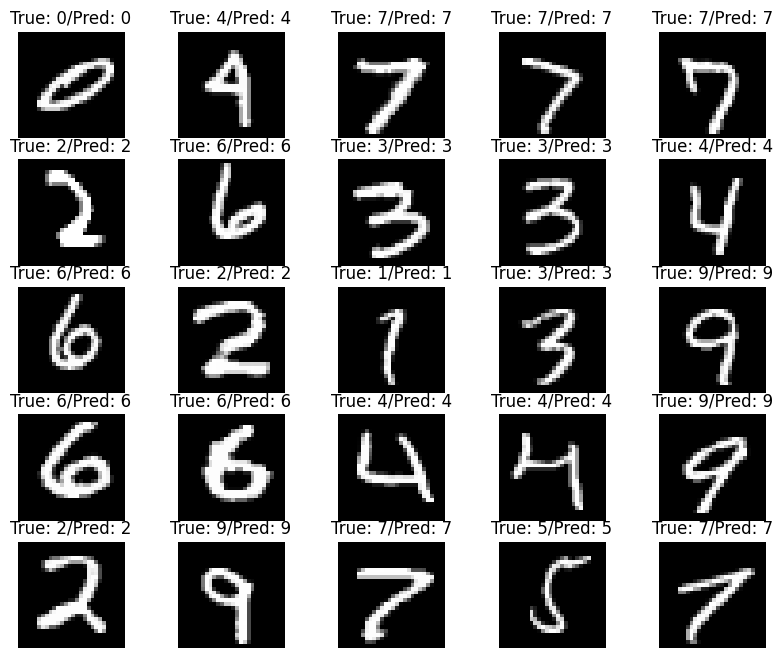

In [9]:
# Run a test batch through the network
images, labels = next(iter(test_loader))
output = model(images)
pred_y = torch.argmax(output, 1)

# Display first 25 images with predicted labels
figure = plt.figure(figsize=(10, 8))
for i in range(25):
    figure.add_subplot(5, 5, i + 1)
    plt.title("True: {}/Pred: {}".format(labels[i].item(), pred_y[i].item()))
    plt.axis("off")
    plt.imshow(images[i, :].squeeze(), cmap="gray")
plt.show()

## Visualising the learnt filters

The first convolution layer in the model learns six single channel $5\times 5$ filters. Let's visualise them to see what they've learnt.

**To do**:

Extract the learnt filters from the conv1 layer of model. Display them as grayscale images.

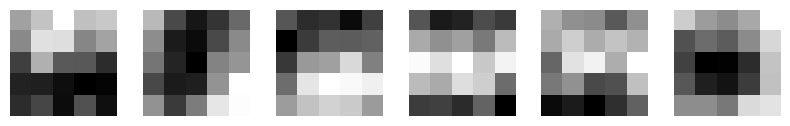

In [10]:
filters = model.conv1.weight
figure = plt.figure(figsize=(10, 8))
for i in range(len(filters)):
    figure.add_subplot(5, 6, i + 1)
    plt.axis("off")
    plt.imshow(filters[i].squeeze(0).detach().numpy(), cmap="gray")
plt.show()

## Visualising the feature maps

As data is passed through a CNN, the tensor after each convolutional layer is referred to as a "feature map" as it still has spatial dimensions (i.e. the tensor will have shape $B\times C\times H\times W$, where $B$ is batch size, $C$ is the number of channels output by that layer and $H$ and $W$ are the height and width of the output tensor).

**To do**:

Write some code to visualise the feature maps as gray scale images. i.e. you should be able to specify a layer and channel and then display this as an image. Display a test input image and then explore the feature maps at different layers. Can you get an impression of what features it is learning?

## Digit recognition as a regression problem

The standard way to solve the MNIST digit recognition task is as a classification task, i.e. for an input image, choose one from 10 discrete classes. We will now try to solve the task as a *regression problem*.

**To do**:

The goal is to modify the above model and training code such that the model outputs a single scalar value which should be close to the value of the actual digit. For example, if the input digit has label 4, if the model outputs 4.2, this would be a pretty good answer (and could be rounded to 4). You will need to:

1. Modify the model to have only a single output.
2. Think about the activation/post-processing you will apply to the final output. You know that your digits lie in the range 0 to 9. Can you think of a way to force the network output into this range? (Hint: remember what `torch.nn.sigmoid` does).
3. Modify the loss function. The labels are classes per input image. Your network will now output a continuous scalar value. You want to penalise larger errors more (e.g. predicting 0.4 when the label is 9 is really bad but predicting 4.2 when the label is 5 is not so bad).
4. You may need to tweak hyperparameters like learning rate now that you have a very different loss and network output.
5. Check that training loss reduces during training. Can you compute an accuracy percentage like we did for classification? (Hint: round the output). How does it compare to the classification solution?
6. Modify the code for visualising input images and predicted labels to show the continuous label.

In [11]:
class LeNetRegr(LeNet):
    def __init__(self):
        super(LeNetRegr, self).__init__()
        self.fc3 = torch.nn.Linear(84, 1)
        self.output_sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = super(LeNetRegr, self).forward(x)
        x = self.output_sigmoid(x) * torch.tensor(9, dtype=torch.float32)
        return x


model_regr = LeNetRegr()
num_epochs = 10
optim = torch.optim.Adam(model_regr.parameters(), lr=0.001)
loss_func = nn.MSELoss()
for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        output = model_regr(images)
        loss = loss_func(output, labels.float().unsqueeze(1))
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss
    print("Total loss over epoch {}: {:.2f}".format(epoch + 1, total_loss))

Total loss over epoch 1: 1694.08
Total loss over epoch 2: 641.99
Total loss over epoch 3: 404.08
Total loss over epoch 4: 304.29
Total loss over epoch 5: 251.66
Total loss over epoch 6: 212.97
Total loss over epoch 7: 183.66
Total loss over epoch 8: 160.81
Total loss over epoch 9: 147.09
Total loss over epoch 10: 125.55


In [12]:
correct = 0
total = 0
for images, labels in test_loader:
    output = model_regr(images)
    pred_y = torch.round(output).int()
    correct += (pred_y == labels.unsqueeze(1)).sum()
    total += float(labels.size(0))
accuracy = correct / total
print(
    "Test Accuracy of the model on the 10000 test images using regression: %.2f"
    % accuracy
)

Test Accuracy of the model on the 10000 test images using regression: 0.93


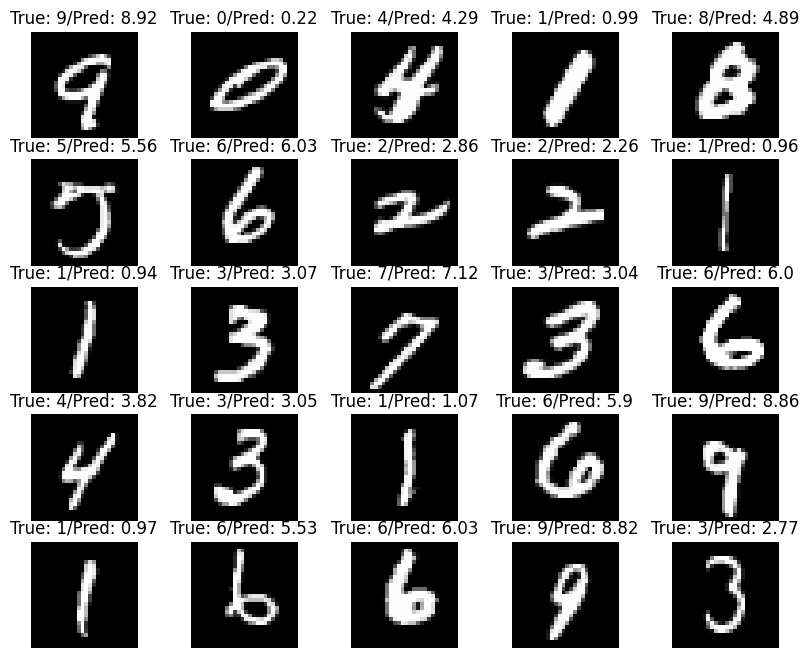

In [13]:
# Run a test batch through the network
images, labels = next(iter(test_loader))
output = model_regr(images)

# Display first 25 images with predicted labels
figure = plt.figure(figsize=(10, 8))
for i in range(25):
    figure.add_subplot(5, 5, i + 1)
    plt.title("True: {}/Pred: {}".format(labels[i].item(), round(output[i].item(), 2)))
    plt.axis("off")
    plt.imshow(images[i, :].squeeze(), cmap="gray")
plt.show()

## Improving the model (highly recommended for Masters-level students)

**To do**:

Now it's time to implement your own alternative model to LeNet (the classification version). I would like you to implement a mini version of the VGG network described in the video lecture. Specifically, aim for more depth (in terms of more convolutional layers) but use $3\times 3$ filters instead of $5\times 5$. Also, use ReLU instead of sigmoid activation and max pooling instead of mean pooling. You can decide how many feature channels to have at each layer. Can you match or improve on the LeNet model performance? Be careful not to add too many parameters overall so that you start overfitting to the training data and making test performance worse.

In [24]:
relu = torch.nn.ReLU()
vgg_ish = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1),
    relu,
    torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
    relu,
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1),
    relu,
    torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1),
    relu,
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(6 * 7 * 7, 256),
    relu,
    torch.nn.Linear(256, 10),
).to("mps")

num_epochs = 10
optim = torch.optim.Adam(vgg_ish.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        output = vgg_ish(images.to("mps"))
        loss = loss_func(output, labels.to("mps"))
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss
    print("Total loss over epoch {}: {:.2f}".format(epoch + 1, total_loss))

Total loss over epoch 1: 274.89
Total loss over epoch 2: 55.86
Total loss over epoch 3: 39.27
Total loss over epoch 4: 30.55
Total loss over epoch 5: 25.06
Total loss over epoch 6: 20.53
Total loss over epoch 7: 17.90
Total loss over epoch 8: 15.17
Total loss over epoch 9: 13.47
Total loss over epoch 10: 11.26


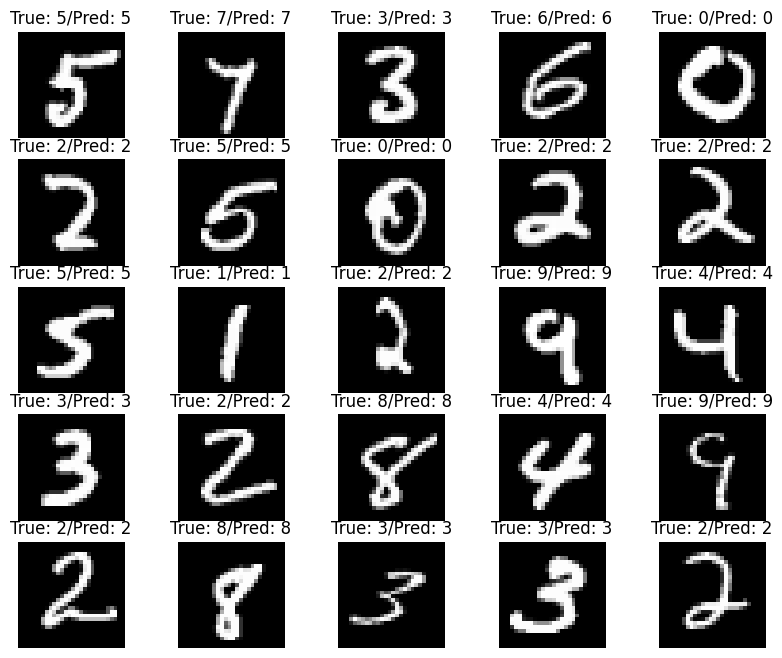

In [25]:
images, labels = next(iter(test_loader))
output = vgg_ish(images.to("mps"))

# Display first 25 images with predicted labels
figure = plt.figure(figsize=(10, 8))
for i in range(25):
    figure.add_subplot(5, 5, i + 1)
    plt.title("True: {}/Pred: {}".format(labels[i].item(), torch.argmax(output[i])))
    plt.axis("off")
    plt.imshow(images[i, :].squeeze(), cmap="gray")
plt.show()

In [26]:
correct = 0
total = 0
for images, labels in test_loader:
    output = vgg_ish(images.to("mps"))
    pred_y = torch.argmax(output, 1)
    correct += (pred_y == labels.to("mps")).sum()
    total += float(labels.size(0))
accuracy = correct / total
print(
    "Test Accuracy of the model on the 10000 test images using regression: %.2f"
    % accuracy
)

Test Accuracy of the model on the 10000 test images using regression: 0.99
